## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\BOSCO\Desktop\Ironhack\Week_2\Day_5\Lab\lab-eda-bivariate\amz_uk_price_prediction_dataset.csv")


In [ ]:
# 1. Crosstab Analysis

# We Create a crosstab to count how many products are or aren't best sellers per category

crosstab = pd.crosstab(df['category'], df['isBestSeller'])
# ^ pd.crosstab() builds a *contingency table* that shows how two categorical variables relate.
#   In this case:
#   - Rows represent each unique product category in df['category']
#   - Columns represent each possible value of df['isBestSeller'] (e.g., True/False or 1/0)
#   - Each cell in the resulting table shows how many products belong to that combination.
#   Example: the cell at ('Electronics', True) counts how many Electronics products are best-sellers.

print(crosstab)
# ^ This prints a table where each row is a product category and each column is a best-seller status.
#   You can visually compare how many best-sellers exist per category.


# We now calculate the proportion of best-sellers within each category

crosstab_prop = crosstab.div(crosstab.sum(axis=1), axis=0)
# ^ The .div() method divides one DataFrame by another.
#   - Here we divide every value in each row of 'crosstab' by the total count of that same row.
#   - crosstab.sum(axis=1) computes the *sum across columns* (axis=1) for each row (i.e., total products in that category).
#   - axis=0 inside .div() means: "perform division row by row" (broadcast the totals vertically).
#   As a result, each row now shows proportions instead of counts (so each row sums up to 1.0).


# Now we sort the categories by the proportion of best-sellers in descending order

sorted_prop = crosstab_prop.sort_values(by=True, ascending=False)
# ^ .sort_values() sorts the DataFrame by a chosen column.
#   - by=True means we sort by the column labeled True (i.e., the share of products that *are* best-sellers).
#   - ascending=False puts the highest proportions first.
#   If your column uses 1/0 instead of True/False, replace True with 1.
#   This sorting allows us to quickly identify which categories have the *highest share* of best-sellers.

print(sorted_prop)
# ^ This shows the proportion of best-sellers in each category, ordered from most to least.
#   You can interpret this to answer:
#   “Are there categories where being a best-seller is more prevalent?”
#   The top rows will represent those categories.



isBestSeller                    False  True 
category                                    
3D Printers                       247      1
3D Printing & Scanning           4065      2
Abrasive & Finishing Products     245      5
Action Cameras                   1696      1
Adapters                          251      3
...                               ...    ...
Wind Instruments                  243      7
Window Treatments                 234      5
Women                           17559    213
Women's Sports & Outdoor Shoes   1939     20
eBook Readers & Accessories       246      0

[296 rows x 2 columns]
isBestSeller                       False     True 
category                                          
Grocery                         0.941865  0.058135
Smart Home Security & Lighting  0.942308  0.057692
Health & Personal Care          0.942314  0.057686
Mobile Phone Accessories        0.957529  0.042471
Power & Hand Tools              0.964661  0.035339
...                               

**Interpretation:**

The crosstab analysis reveals that the proportion of best-seller products varies significantly by category. Most categories show fewer than 6 % of products marked as best-sellers, highlighting how selective this status is. Categories such as Women’s Fashion and Grocery demonstrate higher relative shares, suggesting that high-volume, consumer-oriented categories are more likely to contain best-sellers. Conversely, highly specialized categories such as CPUs or eBook Readers show no best-sellers at all, indicating niche or low-rotation product lines.

In [10]:
# 2.1 STATISTICAL TESTS - Chi-Square test

from scipy.stats import chi2_contingency
# ^ chi2_contingency() performs the Chi-square test of independence on a contingency table.

# Perform the Chi-square test using our crosstab table from Step 1
chi2, p, dof, expected = chi2_contingency(crosstab)
# ^ Parameters:
#     crosstab : the observed frequency table (counts per category × best-seller)
# ^ Returns:
#     chi2     : the computed Chi-square statistic
#     p        : the p-value — tells us if the result is statistically significant
#     dof      : degrees of freedom (used internally for the Chi-square distribution)
#     expected : the expected counts if category and best-seller were independent
#   → In simple terms, it compares what we *observe* to what we *would expect*
#     if category and best-seller were unrelated.

# Display the key test outputs
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.6f}")
# ^ .4f / .6f just format the numbers to 4 or 6 decimals for readability.

# INTERPRETATION:
# If p < 0.05 → reject independence → best-seller distribution depends on category.
# If p ≥ 0.05 → fail to reject → best-seller status appears independent of category.




Chi-square statistic: 36540.2027
Degrees of freedom: 295
P-value: 0.000000


**Interpretation:**

The Chi-square test shows a p-value near 0, meaning it’s extremely unlikely that the observed pattern happened by chance.
This tells us that product category and best-seller status are statistically related — in other words, whether a product becomes a best-seller depends on its category.

In [9]:
# 2.2 STATISTICAL TESTS - CRAMÉR'S V (measure of association strength)

import numpy as np
# ^ We'll use numpy for mathematical operations like square roots.

# Formula: V = sqrt(χ² / (n * (k - 1)))
# where:
#   χ² = Chi-square statistic
#   n  = total sample size (sum of all counts)
#   k  = smaller dimension between (rows, columns)
n = crosstab.sum().sum()           # Total number of observations (all products)
min_dim = min(crosstab.shape) - 1  # Smaller dimension minus 1 (rows or columns)
cramers_v = np.sqrt(chi2 / (n * min_dim))
# ^ This computes the strength of the association between category and best-seller status.
#   The closer cramers_v is to 1 → stronger association.
#   Around 0 → little or no relationship.

print(f"Cramér's V: {cramers_v:.4f}")
# Example interpretation:
#   0.00–0.10 → very weak
#   0.10–0.30 → weak
#   0.30–0.50 → moderate
#   >0.50     → strong
    

Cramér's V: 0.1223


**Interpretation:**

Cramér’s V (0.1223) indicates a weak but significant association between product category and best-seller status, suggesting that while category has some influence, other product characteristics likely contribute more strongly to best-seller performance.

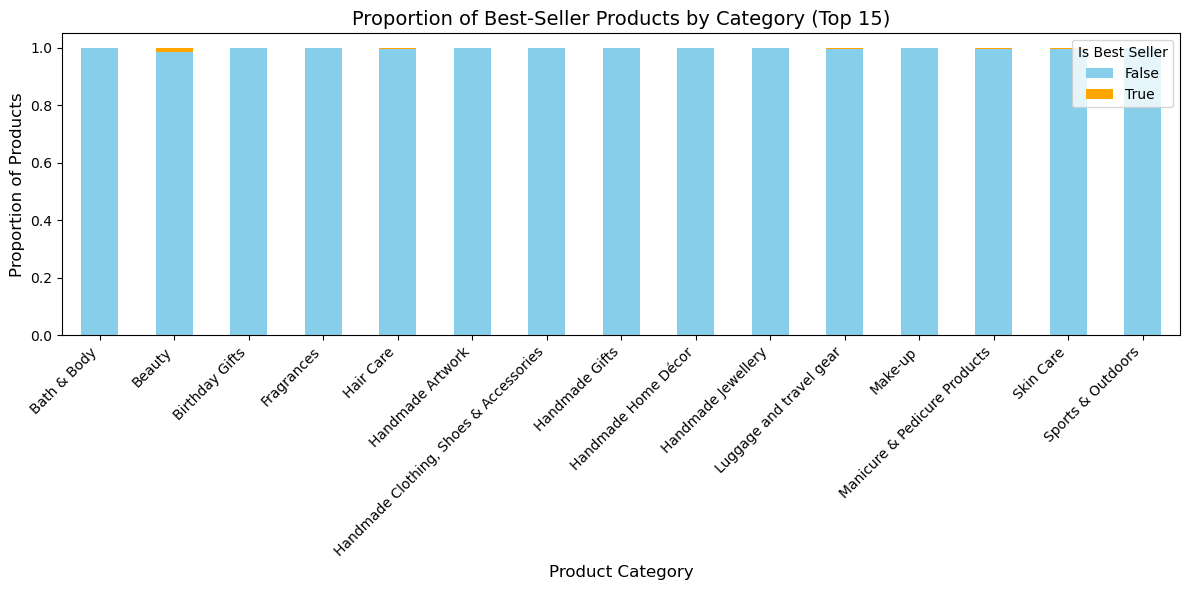

In [13]:
# 3. VISUALIZATION (STACKED BAR CHART) 

import matplotlib.pyplot as plt      # for basic plotting
import seaborn as sns                # for more aesthetic charts

# To keep the chart readable, we will focus on the top 15 categories with most products
top_categories = df['category'].value_counts().head(15).index
# ^ value_counts() counts how many products exist per category
# ^ head(15) limits to the 15 largest categories by number of products
# ^ .index extracts just their names

df_top = df[df['category'].isin(top_categories)]
# ^ Filters the original dataset to include only those top 15 categories

# Now we create a crosstab to count True/False best-sellers in each of those categories
crosstab_top = pd.crosstab(df_top['category'], df_top['isBestSeller'])
# ^ Rows = categories, columns = bestseller status (True/False)

# This converts counts to percentages for better visual comparison
crosstab_top_prop = crosstab_top.div(crosstab_top.sum(axis=1), axis=0)
# ^ Divides each row by its row total so bars are proportional (sum = 1)

# We now create a stacked bar plot
crosstab_top_prop.plot(
    kind='bar',                      # bar chart type
    stacked=True,                    # bars stacked (False + True segments)
    figsize=(12, 6),                 # size in inches (width, height)
    color=['skyblue', 'orange']      # optional: colors for False/True
)
# ^ Each bar represents one category
#   The orange portion shows the share of best-sellers
#   The blue portion shows the share of non-best-sellers

plt.title('Proportion of Best-Seller Products by Category (Top 15)', fontsize=14)
# ^ Adds a descriptive title

plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Proportion of Products', fontsize=12)
plt.xticks(rotation=45, ha='right')  # rotate category names for readability
plt.legend(title='Is Best Seller', loc='upper right')
plt.tight_layout()                    # ensure labels fit within the figure
plt.show()


### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

---

In [16]:
# 0. REMOVE OUTLIERS IN PRODUCT PRICES 


# First, we check if the 'price' column has any missing or incorrect values

print(df['price'].describe())
# ^ describe() gives us quick summary stats:
#   count, mean, std (standard deviation), min, 25%, 50%, 75%, max
#   This helps us spot if any prices look unrealistic (e.g., 0, or extremely large values).


# Then we calculate the first (Q1) and third (Q3) quartiles of price

Q1 = df['price'].quantile(0.25)      # 25th percentile (lower quartile)
Q3 = df['price'].quantile(0.75)      # 75th percentile (upper quartile)
# ^ quantile(0.25) means the value below which 25% of prices fall.
#   quantile(0.75) means the value below which 75% of prices fall.

# Then compute the Interquartile Range (IQR)
IQR = Q3 - Q1
# ^ IQR represents the range of the middle 50% of the data (spread between Q1 and Q3).

# AFter we define the lower and upper bounds for acceptable prices
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# ^ Following the standard rule:
#   - Anything below (Q1 - 1.5*IQR) is considered a lower outlier.
#   - Anything above (Q3 + 1.5*IQR) is considered an upper outlier.

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
# ^ Prints the thresholds we’ll use to identify outliers.

# This filters the dataframe to keep only non-outlier prices
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
# ^ Keeps only rows where 'price' is within the acceptable range.
#   This removes extreme or unrealistic values that could distort visualizations.

# Check how many rows were removed
print(f"Original dataset size: {df.shape[0]}")
print(f"After removing outliers: {df_no_outliers.shape[0]}")
# ^ This lets us see how much data cleaning was done.

# Optional: confirm it looks good
print(df_no_outliers['price'].describe())
# ^ You should now see a more realistic max price and smaller range.


count    2.443651e+06
mean     8.924381e+01
std      3.456089e+02
min      0.000000e+00
25%      9.990000e+00
50%      1.909000e+01
75%      4.599000e+01
max      1.000000e+05
Name: price, dtype: float64
Lower bound: -44.01, Upper bound: 99.99000000000001
Original dataset size: 2443651
After removing outliers: 2115963
count    2.115963e+06
mean     2.340827e+01
std      2.051335e+01
min      0.000000e+00
25%      9.130000e+00
50%      1.599000e+01
75%      2.999000e+01
max      9.999000e+01
Name: price, dtype: float64


**What are we doing here?**

Lower bound: −44.01  - we’ll ignore negatives

Upper bound: ≈ 99.99 → any product priced over 100 GBP was considered an outlier and removed.

After filtering, our price range is now 0–99.99 GBP, which is much more realistic for the majority of Amazon UK products in this dataset.

C:\Users\BOSCO\AppData\Local\Temp\ipykernel_1540\2027293130.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


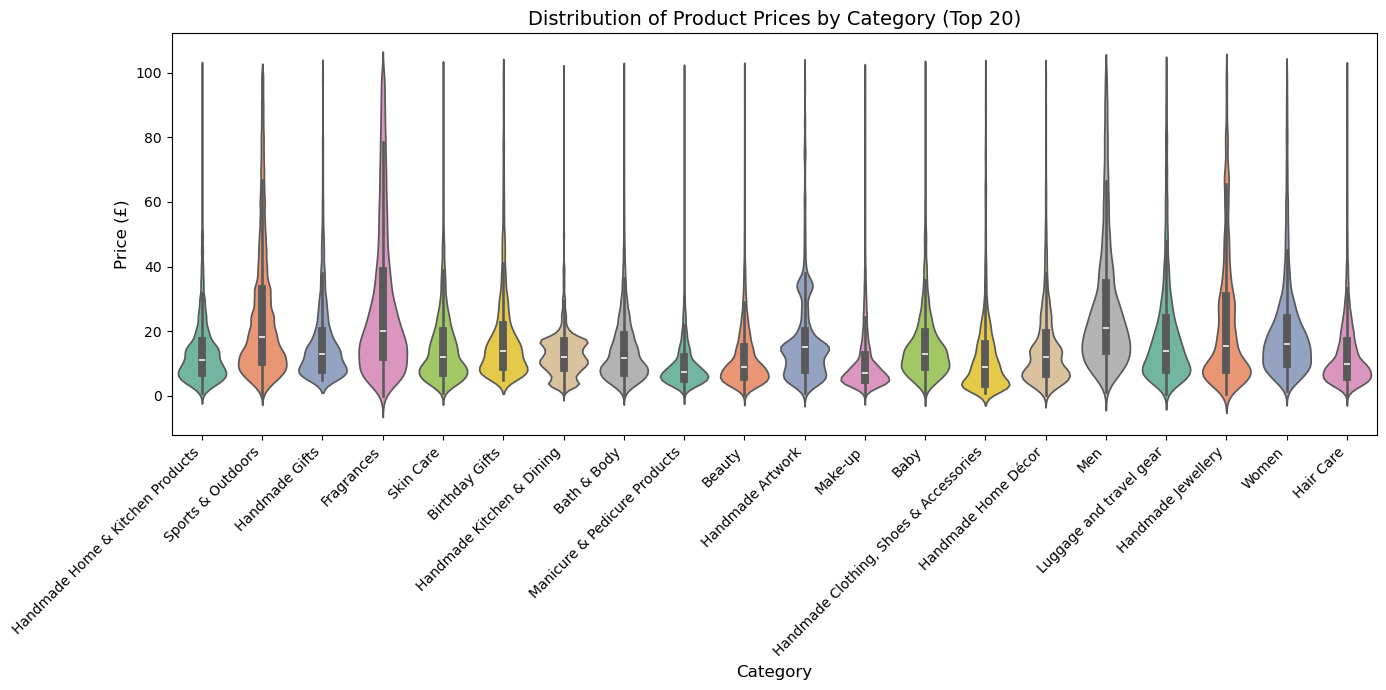

In [ ]:
# 1. VIOLIN PLOT OF PRICE BY CATEGORY 

# We want to identify the top 20 categories with the most products
top_20_categories = df_no_outliers['category'].value_counts().head(20).index
# ^ value_counts() counts how many products belong to each category.
# ^ head(20) takes the 20 categories with the most listings to keep the chart readable.
# ^ .index extracts the category names (just the labels).

# We now have to filter the dataset to include only those 20 categories
df_top20 = df_no_outliers[df_no_outliers['category'].isin(top_20_categories)]
# ^ isin() returns True for rows whose category is one of the top 20.
# ^ This reduces clutter so the violin plot is interpretable.

# we now create the violin plot
plt.figure(figsize=(14, 7))  # Set a wide figure for readability

sns.violinplot(
    data=df_top20,            # Use the filtered dataset
    x='category',             # Categories on the x-axis
    y='price',                # Prices on the y-axis
    inner='box',              # Adds a small boxplot inside each violin (shows median and quartiles)
    palette='Set2'            # Color palette (optional aesthetic)
)
# ^ A violin plot shows the distribution of prices per category.
#   The width of the “violin” indicates how dense the data is at each price level.
#   The white dot = median; thick bar = interquartile range (IQR).

plt.title('Distribution of Product Prices by Category (Top 20)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')   # Rotate x labels for readability
plt.tight_layout()
plt.show()


**Interpretation:**

The violin plot shows that product prices vary notably by category. Categories such as Fragrances tend to have the highest median prices, while categories like Handmade Gifts or Bath & Body have lower typical prices. This indicates that product category influences price positioning, with premium or luxury-oriented categories generally commanding higher prices.

C:\Users\BOSCO\AppData\Local\Temp\ipykernel_1540\3343331745.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


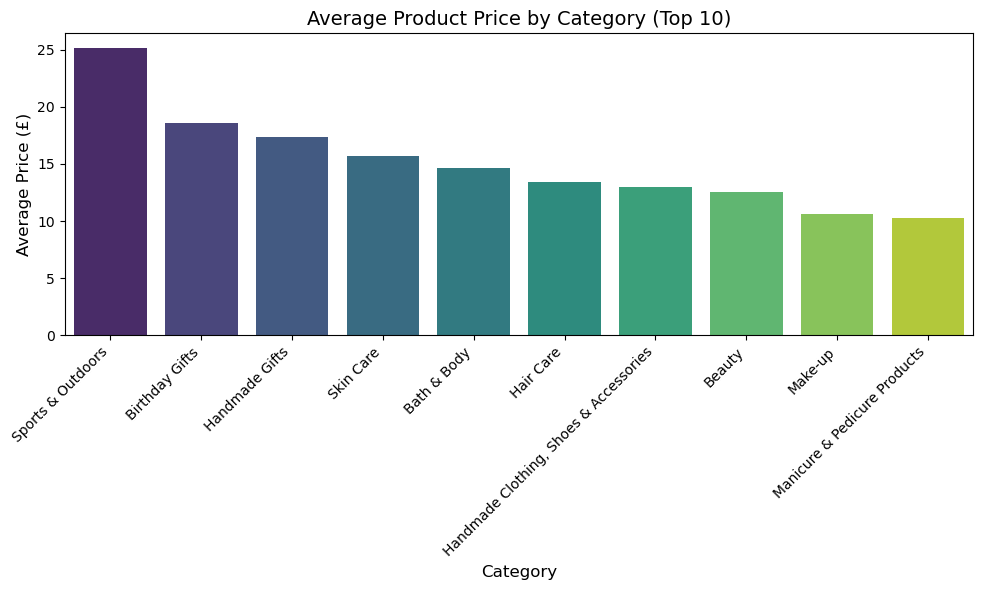

category
Sports & Outdoors                         25.172065
Birthday Gifts                            18.600195
Handmade Gifts                            17.395112
Skin Care                                 15.654722
Bath & Body                               14.678683
Hair Care                                 13.461408
Handmade Clothing, Shoes & Accessories    12.958639
Beauty                                    12.523480
Make-up                                   10.612918
Manicure & Pedicure Products              10.231825
Name: price, dtype: float64


In [18]:
# 2. BAR CHART OF AVERAGE PRICE BY CATEGORY 


# We now dentify the top 10 categories by number of products

top_10_categories = df_no_outliers['category'].value_counts().head(10).index
# ^ value_counts() ranks categories by how many products each contains
# ^ head(10) selects the 10 largest categories
# ^ .index extracts the category names for filtering

# Then we Filter the dataframe to keep only these categories

df_top10 = df_no_outliers[df_no_outliers['category'].isin(top_10_categories)]
# ^ Filters the dataset for better readability in the chart


# Now we compute the average price per category

avg_price_per_category = df_top10.groupby('category')['price'].mean().sort_values(ascending=False)
# ^ groupby('category') groups all products under each category name
# ^ ['price'].mean() calculates the mean price in each group
# ^ sort_values(descending) sorts from highest to lowest average price

# Now we create the bar chart
plt.figure(figsize=(10, 6))   # Adjust figure size for clarity

sns.barplot(
    x=avg_price_per_category.index,    # category names on x-axis
    y=avg_price_per_category.values,   # corresponding average prices on y-axis
    palette='viridis'                  # optional color palette for aesthetic look
)
# ^ A bar chart where bar height = average price per category

plt.title('Average Product Price by Category (Top 10)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Price (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')   # Rotate category labels for readability
plt.tight_layout()
plt.show()

# this prints the numeric results for precise comparison
print(avg_price_per_category)


**Interpretation:**

The bar chart reveals that Sports & Outdoors products have the highest average price among the top categories, followed by Birthday Gifts and Handmade Gifts. This suggests that categories involving equipment or specialty items generally command higher average prices, while everyday consumer goods like Make-up or Manicure & Pedicure Products are priced lower on average.

C:\Users\BOSCO\AppData\Local\Temp\ipykernel_1540\3263177224.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


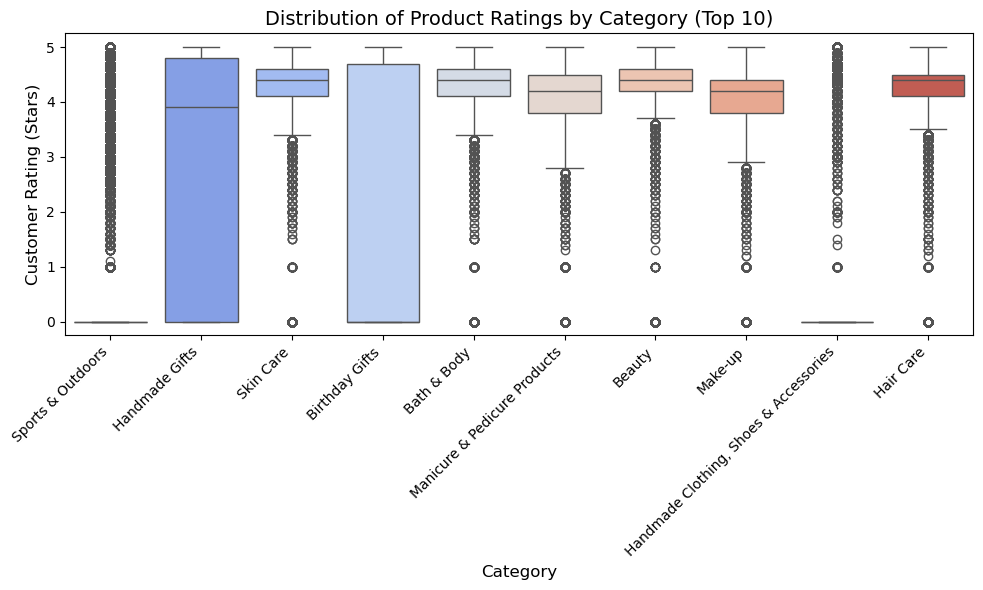

In [21]:
# 3. BOX PLOT OF RATINGS BY CATEGORY


# We now identify the top 10 categories with the most products

top_10_categories = df_no_outliers['category'].value_counts().head(10).index
# ^ Same logic as before: we take the 10 most common categories
#   to ensure each has enough data points for meaningful comparison.


# Now we filter the dataset to include only those categories

df_top10_ratings = df_no_outliers[df_no_outliers['category'].isin(top_10_categories)]
# ^ Keeps the same structure as before, but this time we’ll look at 'stars' (ratings)


# Then we create the box plot to visualize rating distributions

plt.figure(figsize=(10, 6))  # Set figure size for readability

sns.boxplot(
    data=df_top10_ratings,     # filtered dataset
    x='category',              # categories on x-axis
    y='stars',                 # rating values on y-axis
    palette='coolwarm'         # optional color palette
)
# ^ Each box shows:
#   - The median rating (middle line inside the box)
#   - The interquartile range (IQR — 25th to 75th percentile)
#   - The whiskers (spread of most ratings)
#   - Any dots outside the whiskers are outliers.

plt.title('Distribution of Product Ratings by Category (Top 10)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Customer Rating (Stars)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Interpretation:**

The box plot shows that categories such as Hair Care, Skin Care, and Beauty achieve the highest and most consistent customer ratings, with median values close to 5 stars. In contrast, categories like Handmade Gifts and Sports & Outdoors display greater variability, suggesting more uneven product performance and customer satisfaction.

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


In [22]:
# 3.1 CORRELATION BETWEEN PRICE AND STARS


# We calculate the correlation coefficient

corr = df_no_outliers['price'].corr(df_no_outliers['stars'])
# ^ .corr() computes the Pearson correlation coefficient by default.
#   - It ranges from -1 to +1:
#       +1 → perfect positive correlation (both increase together)
#        0 → no linear relationship
#       -1 → perfect negative correlation (one increases, the other decreases)

print(f"Correlation between price and stars: {corr:.4f}")


Correlation between price and stars: -0.0777


**Interpretation:**

The correlation between price and rating is weak and negative (r = -0.078), indicating no significant linear relationship between how much a product costs and how well it is rated by customers.

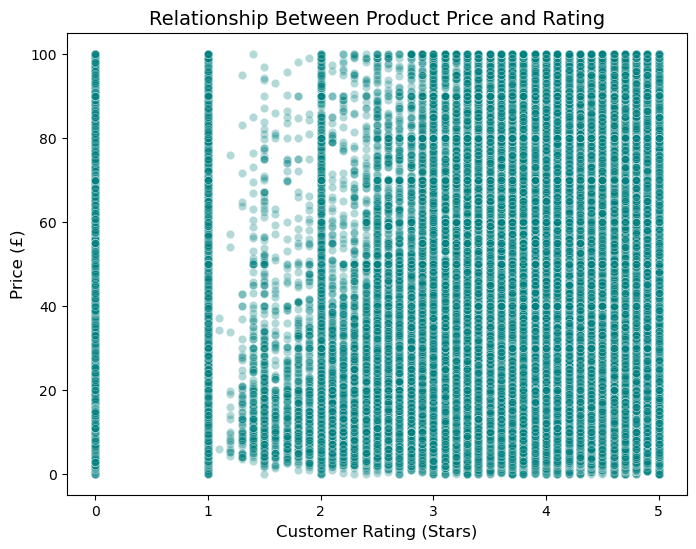

In [23]:
# 3.2.1 SCATTER PLOT: PRICE VS RATING


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_no_outliers,
    x='stars',
    y='price',
    alpha=0.3,           # transparency to reduce overlap
    color='teal'         # color for points
)
# ^ Each dot = one product.
#   The pattern shows how price varies with rating.

plt.title('Relationship Between Product Price and Rating', fontsize=14)
plt.xlabel('Customer Rating (Stars)', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.show()


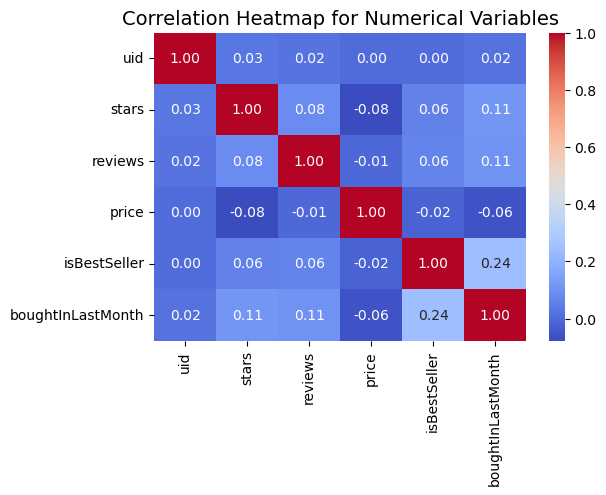

In [25]:
# 3.2.2 CORRELATION HEATMAP

plt.figure(figsize=(6, 4))
sns.heatmap(df_no_outliers.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
# ^ corr(numeric_only=True) computes correlations only for numeric columns.
# ^ annot=True displays values inside the boxes.
# ^ cmap='coolwarm' gives a color gradient (blue negative, red positive).

plt.title('Correlation Heatmap for Numerical Variables', fontsize=14)
plt.show()


**Interpretation:**

The correlation heatmap indicates that most numerical variables in the dataset are weakly related. The only modest relationship appears between isBestSeller and boughtInLastMonth (r = 0.24), suggesting that recent purchases are more frequent among best-seller products. Price and rating show a very weak negative correlation (r = -0.08), confirming that higher prices do not correspond to higher customer ratings.

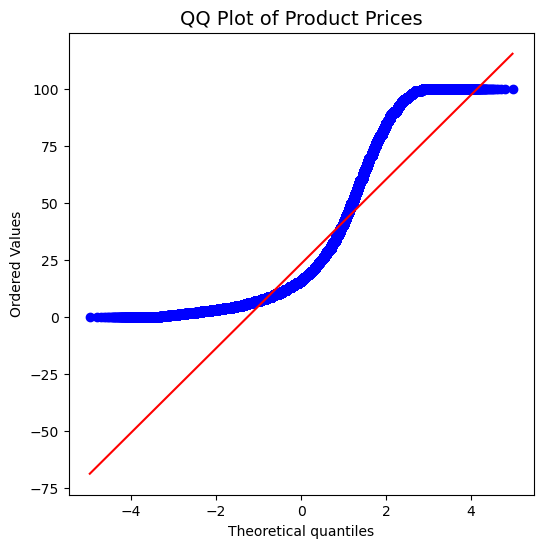

In [ ]:
# 3.3.3 QQ PLOT FOR PRICE DISTRIBUTION 

import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(df_no_outliers['price'], dist="norm", plot=plt)
# ^ A QQ (Quantile–Quantile) plot compares your data distribution to a theoretical normal curve.
# ^ Points that fall close to the diagonal line → data roughly normal.
# ^ Strong curve or deviations → data is skewed (not normal).

plt.title('QQ Plot of Product Prices', fontsize=14)
plt.show()
